## GANs from cs231n with SETI data set

Running this on Floydhub

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import os
import torch.multiprocessing as multiprocessing

from torch.utils.data import Dataset
import torchvision.transforms as transforms

from skimage import io, transform

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

In [2]:
dtype = torch.FloatTensor
#dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

In [3]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples


## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

Hint: use `torch.rand`.

In [4]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    return torch.rand(batch_size, dim).uniform_(-1,1)


## Flatten

Recall our Flatten operation from previous notebooks... this time we also provide an Unflatten, which you might want to use when implementing the convolutional generator. We also provide a weight initializer (and call it for you) that uses Xavier initialization instead of PyTorch's uniform default.

In [6]:

class Flatten(nn.Module):
    def forward(self, x):
        N = 0
        try:
            N, C, H, W = x.size() # read in N, C, H, W
        except ValueError: 
            N, H, W = x.size() # spectrograms do not have the C dimension
        return x.view(N, -1)  # "flatten" the  H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform(m.weight.data)

## CPU / GPU
By default all code will run on CPU. GPUs are not needed for this assignment, but will help you to train your models faster. If you do want to run the code on a GPU, then change the `dtype` variable in the following cell.

In [8]:

LABELS = [
    'brightpixel',
    'narrowband',
    'narrowbanddrd',
    'noise',
    'squarepulsednarrowband',
    'squiggle',
    'squigglesquarepulsednarrowband'
]

LABEL_TO_ID = {label: label_i for label_i, label in enumerate(LABELS)}


class setiDataset(Dataset):
    def __init__(self, directory, index_file, transform = None):
        self.directory = directory
        lines = open(index_file, 'r').readlines()[1:]
        self.filelist = [tuple(line.strip().split(',',1)) for line in lines]
        self.transform = transform
        
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self, key):
        raw_file = open('%s%s.dat' % (self.directory, self.filelist[key][0]), 'rb')
        aca = ibmseti.compamp.SimCompamp(raw_file.read())
        spectrogram = aca.get_spectrogram()
        
        if self.transform:
            spectrogram = self.transform(spectrogram)
            
        #tensor = torch.from_numpy(spectrogram).float().view(1, 384, 512)
        
        return spectrogram, self.filelist[key][0], LABEL_TO_ID[self.filelist[key][1]]
        

class setiProcessedDataset(Dataset):
    def __init__(self, directory, index_file, transform = None):
        self.directory = directory
        lines = open(index_file, 'r').readlines()[1:]
        self.filelist = [tuple(line.strip().split(',',1)) for line in lines]
        self.transform = transform
        
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self, key):
        spectrogram = np.load(os.path.join(self.directory, self.filelist[key][0] + ".dat.npy"))
        
        if self.transform:
            spectrogram = self.transform(spectrogram)
            
        #tensor = torch.from_numpy(spectrogram).float().view(1, 384, 512)
        
        return spectrogram, self.filelist[key][0], LABEL_TO_ID[self.filelist[key][1]]
    
class ScaleToPlusMinus(object):
    def __call__(self, spect):
        return preprocess_img(spect)
    
    
class ScaleToPositive(object):
    def __call__(self, spect):
        return deprocess_img(spect)
    
    
class Resize(object):
    """Resize the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, spect):
        
        h, w = spect.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        return transform.resize(spect, (new_h, new_w))

# class ToTensor(object):
#     """Convert ndarrays in sample to Tensors."""

#     def __call__(self, spectrogram):

#         # swap color axis because
#         # numpy image: H x W x C
#         # torch image: C X H X W
#         spectrogram = spectrogram.transpose((2, 0, 1))
#         return spectrogram

In [9]:
NUM_TRAIN = int(0.7*19197)
NUM_VAL = int(0.3*19197)

NOISE_DIM = 96
batch_size = 8

reduced_size = 128

#composed = transforms.Compose([Resize((reduced_size,reduced_size)), ToTensor()])
composed = transforms.Compose([Resize((reduced_size,reduced_size))])

#seti_train = setiDataset('cs231n/datasets/seti/data/', 'cs231n/datasets/seti/data/public_list_primary_v3_medium_21june_2017.csv', transform=composed)
seti_train = setiProcessedDataset('/seti_data_small/', '/seti_data_small/public_list_primary_v3_medium_21june2017_onlylargeamp.csv', transform=None)
# loader_train = DataLoader(seti_train, batch_size=batch_size,
#                           shuffle=False, sampler=ChunkSampler(NUM_TRAIN, 0))
loader_train = DataLoader(seti_train, batch_size=batch_size,
                          shuffle=True)

In [12]:
def show_spectrograms(batch, width, height):
    images, labels = None, None
    areLabels = False
    try:
        images, uuids, labels = batch
        areLabels = True
    except Exception:
        images = batch
        
    
    images = images.view(-1, width*height).numpy().squeeze() #convert from Tensor to numpy
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(5*sqrtn/2, 5*sqrtn/2))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        thisLabel = 'na'
        if areLabels:
            thisLabel = LABELS[labels[i]]
        ax.set_title('{0}\n amp: {1:.4e}'.format(thisLabel, np.max(img)))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        img = img.reshape(width, height)
        if np.min(img) < 0: 
            img = deprocess_img(img)
        plt.imshow(np.log(img), aspect = float(img.shape[1]) / img.shape[0], cmap='gray')
    return 

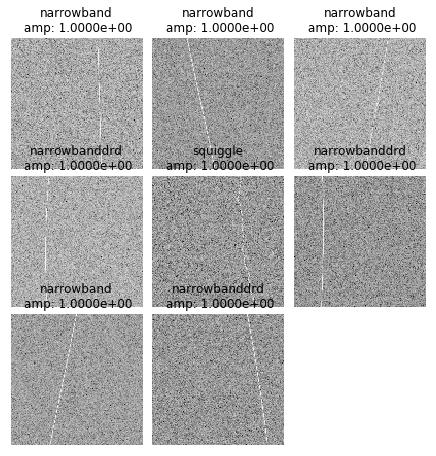

In [13]:


nextbatch = loader_train.__iter__().next()
imgs = nextbatch[0].view(batch_size, reduced_size*reduced_size).numpy().squeeze()

#show_spectrograms(nextbatch, 384, 512)
show_spectrograms(nextbatch, reduced_size, reduced_size)

# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `bce_loss` function defined below to compute the binary cross entropy loss which is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = y * \log(s) + (1 - y) * \log(1 - s) $$

A naive implementation of this formula can be numerically unstable, so we have provided a numerically stable implementation for you below.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:


`true_labels = Variable(torch.ones(size)).type(dtype)`

Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.  **The averaging is already incorporated into the `bce_loss` function below!**


In [14]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Variable of shape (N, ) giving scores.
    - target: PyTorch Variable of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Variable containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()  #HERE is the averaging!

In [15]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    loss = None
    N,_ = logits_real.size()
    N_f,_ = logits_fake.size()
    assert N == N_f
    #print(logits_real.data)
    #print(logits_fake.data)

    #print(N)
    #print(N_f)
    
    real_labels = Variable(torch.ones(N)).type(dtype)
    fake_labels = Variable(torch.zeros(N_f)).type(dtype)

    loss =  bce_loss(logits_real,real_labels)
    loss += bce_loss(logits_fake, fake_labels)
    #loss /= (N + N_f)
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing the (scalar) loss for the generator.
    """
    loss = None
    N_f,_ = logits_fake.size()
    fake_labels = Variable(torch.ones(N_f)).type(dtype)  #note! We make these 'ones' because we're maximizing the prob that the discriminator gets it wrong
    loss = bce_loss(logits_fake, fake_labels)
    return loss

# Optimizing our loss
Make a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. You'll use this to construct optimizers for the generators and discriminators for the rest of the notebook.

In [16]:
def get_optimizer(model, lr = 1e-3, b1 =0.5, b2=0.999):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = None

    optimizer = optim.Adam(model.parameters(),lr=lr,betas=(b1,b2))
    return optimizer

## Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [17]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Variable containing the loss.
    """
    loss = None
    N,_ = scores_real.size()
    loss = 0.5* torch.mean(torch.pow(scores_real - Variable(torch.ones(N)).type(dtype), 2)) + 0.5* torch.mean(torch.pow(scores_fake.type(dtype), 2))
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Variable containing the loss.
    """
    loss = None
    N_f,_ = scores_fake.size()
    loss = 0.5*torch.mean(torch.pow(scores_fake - Variable(torch.ones(N_f)).type(dtype), 2))
    return loss

# Simple Discriminator/Classifier

Implemented below

Our first step is to build a discriminator. Fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms. The architecture is:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

# Simple Generator

Implemented below

Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * ReLU
 * Fully connected layer with size 1024 
 * ReLU
 * Fully connected layer with size 784
 * TanH
   * To clip the image to be [-1,1]

# Deeply Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks 

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly. 
* Reshape into image tensor (Use Unflatten!)
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode. 
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Reshape into Image Tensor
* 64 conv2d^T filters of 4x4, stride 2, 'same' padding, ReLU
* BatchNorm
* 1 conv2d^T filter of 4x4, stride 2, 'same' padding, TanH
* Should have a 28x28x1 image, reshape back into 784 vector

In [18]:
def simple_classifier():
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    
    model = nn.Sequential(
        Flatten(),
        nn.Linear(reduced_size*reduced_size, 256),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Linear(256, 256),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Linear(256, 1)
    )
    return model

def simple_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024,1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024,reduced_size*reduced_size),
        nn.Tanh()
        
        #nn.ReLU(inplace=True),
        #nn.Tanh()
        
        #nn.Tanh(),
        #nn.ReLU()
    )
    return model

def build_dc_classifier(inputsize=28):
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    
    must be square input
    """
    #size after first conv2d
    numfilters1 = 16
    k1 = 3
    s1 = 1
    p1 = 0
    h1 = int(1 + (inputsize - k1 - 2*p1)/s1)
    
    #size after maxpool2d with dilation = 1
    s2 = 2
    p2 = 0
    k2 = 2
    h2 = int(1 + (h1 - k2)/s2)
    
    #size after second conv2d
    numfilters2 = 32
    k3 = 3
    p3 = 0
    s3 = 1
    h3 = int(1 + (h2 - k3 - 2*p3)/s3)
    
    #size after second maxpool2d with dilation=1
    s4 = 2
    p4 = 0
    k4 = 2
    h4 = int(1 + (h3 - k4)/s4)
    
    return nn.Sequential(
        ###########################
        ######### TO DO ###########
        ###########################
        Unflatten(batch_size, 1, inputsize, inputsize),
        nn.Conv2d(1, numfilters1, kernel_size=k1, stride=s1, padding=p1),  #N x h1*h1*numfilters1 after this step, 
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        #nn.ReLU(inplace=True),
        nn.MaxPool2d(k2, stride=s2, padding=p2, dilation=1, return_indices=False, ceil_mode=False), #N x h2*h2*numfilters1 after this step
        nn.Conv2d(numfilters1, numfilters2, stride=s3, padding=p3, kernel_size=k3),  #N x h3*h3*numfilters2 after this
        
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        #nn.ReLU(inplace=True),
        nn.MaxPool2d(k4, stride=s4, padding=p4, dilation=1, return_indices=False, ceil_mode=False), #N x h4*h4*numfilters2
        
        Flatten(), #N
        nn.Linear(h4*h4*numfilters2, 4*4*numfilters2),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        #nn.ReLU(inplace=True),
        nn.Linear(4*4*numfilters2, 1)
    )

def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    
    ssize = 48  #need to figure out how to calculate output size... but this is the number I need below 
    #to generate an output array of 192 * 192, which is the same size as the input spectrograms
    
    ssize = 32  # this is the right value for 128 * 128 sized spectrogram. Ha! that's an exact scale 32 = 48 * 128 / 192
    
    ssize = 32*4 #
    return nn.Sequential(
        ###########################
        ######### TO DO ###########
        ###########################
        #works with ssize = 32
#         nn.Linear(noise_dim, 1024),
#         nn.ReLU(inplace=True),
#         nn.BatchNorm1d(1024),
#         nn.Linear(1024, ssize*ssize*8),
#         nn.ReLU(inplace=True),
#         nn.BatchNorm1d(ssize*ssize*8),
#         Unflatten(-1, 8, ssize, ssize),
        
        ##works with ssize=32*4
        nn.Linear(noise_dim, ssize*ssize*8),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(ssize*ssize*8),
        Unflatten(-1, 8, ssize, ssize),
        
        #previously
        #nn.ConvTranspose2d(8, 64, kernel_size=4, stride=2, padding=1),
        #nn.ReLU(inplace=True),
        #nn.BatchNorm2d(64),
        #nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
        
        nn.ConvTranspose2d(8, 64, kernel_size=3, stride=1, padding=1),  #I think I need to make these convTranspose2d steps smaller kernel/stride in order to give them finer grain resolution
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 128, kernel_size=3, stride=1, padding=1),  #I think I need to make these convTranspose2d steps smaller kernel/stride in order to give them finer grain resolution
        
        
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128, 1, kernel_size=3, stride=1, padding=1),
        
        nn.Tanh(),
        #nn.ReLU(inplace=True),
        #nn.Tanh(),
        Flatten()
        
    )

In [19]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    for epoch in range(num_epochs):
        for x, uuid, label in loader_train:
            #print(iter_count)
            
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = Variable(x).type(dtype)
            #print(real_data.size())
            #print((2* (real_data - 0.5)).size())
            logits_real = D(2* (real_data - 0.5)).type(dtype)
            #print('disciminator')
            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed).detach().view(batch_size, 1, reduced_size, reduced_size)
            #print(fake_images.size())
            logits_fake = D(fake_images.view(batch_size, 1, reduced_size, reduced_size))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, reduced_size, reduced_size))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            #print('...pass')
            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.data[0],g_error.data[0]))
                images = fake_images.data.cpu()[0:16]
                show_spectrograms(images, reduced_size, reduced_size)
                plt.show()
                print()
            iter_count += 1

In [21]:
NUM_TRAIN = int(0.7*19197)
NUM_VAL = int(0.3*19197)

NOISE_DIM = 448*2
batch_size = 32

reduced_size = 128

#composed = transforms.Compose([Resize((reduced_size,reduced_size)), ToTensor()])
#composed = transforms.Compose([Resize((reduced_size,reduced_size))])
composed = transforms.Compose([ScaleToPlusMinus()])

#seti_train = setiDataset('cs231n/datasets/seti/data/', 'cs231n/datasets/seti/data/public_list_primary_v3_medium_21june_2017.csv', transform=composed)
seti_train = setiProcessedDataset('/seti_data_small/', '/seti_data_small/public_list_primary_v3_medium_21june2017_onlylargeamp.csv', 
                                  transform=composed)
# loader_train = DataLoader(seti_train, batch_size=batch_size,
#                           shuffle=False, sampler=ChunkSampler(NUM_TRAIN, 0))
loader_train = DataLoader(seti_train, batch_size=batch_size,
                          shuffle=True)

Iter: 0, D: 1.243, G:0.4583


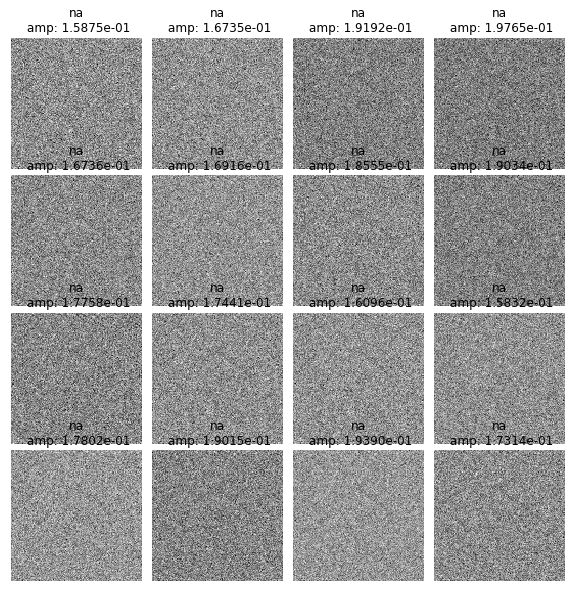


Iter: 200, D: 0.2546, G:0.00775


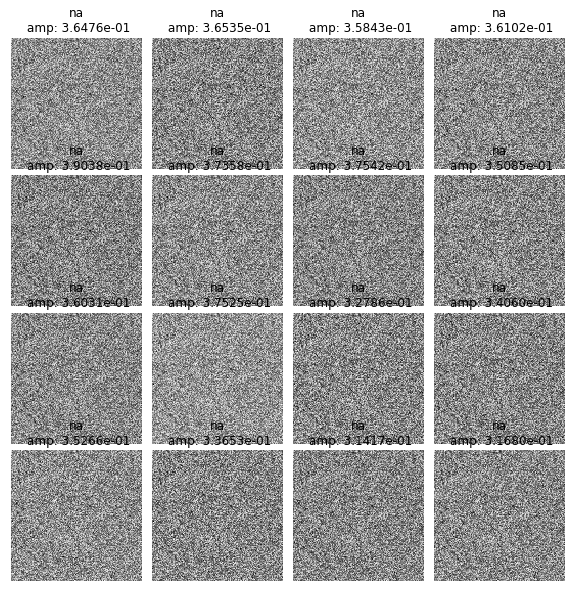

KeyboardInterrupt: 

In [ ]:
#clsifier = build_dc_classifier(reduced_size).type(dtype)
clsifier = simple_classifier().type(dtype)
clsifier.apply(initialize_weights)

#genRator = build_dc_generator().type(dtype)
genRator = simple_generator().type(dtype)

genRator.apply(initialize_weights)

clsifier_solver = get_optimizer(clsifier, lr=1e-3)
genRator_solver = get_optimizer(genRator, lr=1e-5,b1= 0.99, b2=0.99)


run_a_gan(clsifier,genRator, clsifier_solver, genRator_solver, ls_discriminator_loss, ls_generator_loss, num_epochs=5, show_every=200, batch_size=batch_size)